# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \mathcal{C} (\boldsymbol{b})^\top \boldsymbol{S}^\top  ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $



In [1]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# No Subsampling --> Perfect Recovery?

(512, 512)


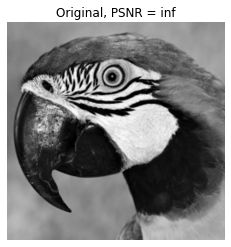

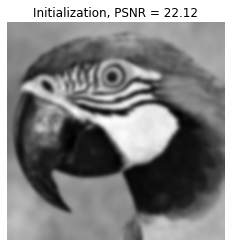

In [57]:
height = 512
width = 512

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=.0, blur_size_x=25, blur_size_y=25,  scale_percent=100)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 511.5, 511.5, -0.5)

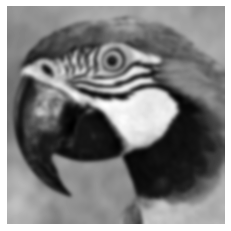

In [58]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [59]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.005, patch_size=3, patch_distance=6, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=1.5, tt=200, verbose=True)

0 Before denoising:  23.190186267066046
0 After denoising:  23.186575489287318
1 Before denoising:  23.689406468518612
1 After denoising:  23.682678456250166
2 Before denoising:  23.99732854759481
2 After denoising:  23.987126936576757
3 Before denoising:  24.21371075796158
3 After denoising:  24.20108879500679
4 Before denoising:  24.377828271071827
4 After denoising:  24.363170576149283
5 Before denoising:  24.50800552333738
5 After denoising:  24.491956932510377
6 Before denoising:  24.61466579578134
6 After denoising:  24.597747153925514
7 Before denoising:  24.704301088557425
7 After denoising:  24.68680056177062
8 Before denoising:  24.781099262514594
8 After denoising:  24.763150753298397
9 Before denoising:  24.847868767000904
9 After denoising:  24.83001982624937
10 Before denoising:  24.90706650105924
10 After denoising:  24.889542190586017
11 Before denoising:  24.960315536946442
11 After denoising:  24.94333137419385
12 Before denoising:  25.008880477155632
12 After denoisi

102 After denoising:  26.1789400347709
103 Before denoising:  26.188815732517735
103 After denoising:  26.18476942529554
104 Before denoising:  26.19453985273085
104 After denoising:  26.190543715388227
105 Before denoising:  26.200210147487212
105 After denoising:  26.196278278071933
106 Before denoising:  26.205842244714844
106 After denoising:  26.20196519248884
107 Before denoising:  26.211428192021003
107 After denoising:  26.207595208175874
108 Before denoising:  26.21695875871683
108 After denoising:  26.21316725806931
109 Before denoising:  26.222433203526364
109 After denoising:  26.218686912515015
110 Before denoising:  26.227857532353074
110 After denoising:  26.224160089882915
111 Before denoising:  26.233237759687043
111 After denoising:  26.229588248253542
112 Before denoising:  26.238574728015074
112 After denoising:  26.23497240381926
113 Before denoising:  26.243868773600198
113 After denoising:  26.240310342250986
114 Before denoising:  26.249117891527803
114 After de

202 After denoising:  26.598652551139498
203 Before denoising:  26.602751147724767
203 After denoising:  26.60176878300949
204 Before denoising:  26.605837980131803
204 After denoising:  26.60487153704047
205 Before denoising:  26.60891153939601
205 After denoising:  26.607960962856033
206 Before denoising:  26.611971995398033
206 After denoising:  26.61103748722504
207 Before denoising:  26.615019793886027
207 After denoising:  26.61410122394015
208 Before denoising:  26.61805506632095
208 After denoising:  26.617152014008877
209 Before denoising:  26.621077678448508
209 After denoising:  26.62019002031265
210 Before denoising:  26.624087802545983
210 After denoising:  26.623215464900287
211 Before denoising:  26.62708561533677
211 After denoising:  26.6262272255212
212 Before denoising:  26.63007002891218
212 After denoising:  26.62922527801225
213 Before denoising:  26.633041001463877
213 After denoising:  26.63221080670937
214 Before denoising:  26.635999760941942
214 After denoisi

302 After denoising:  26.854758297003002
303 Before denoising:  26.85701175279986
303 After denoising:  26.856852585999963
304 Before denoising:  26.859095222477936
304 After denoising:  26.858939016807994
305 Before denoising:  26.861170932983217
305 After denoising:  26.86101777078974
306 Before denoising:  26.86323906533311
306 After denoising:  26.86308868756944
307 Before denoising:  26.865299455807794
307 After denoising:  26.865151399652856
308 Before denoising:  26.8673517408156
308 After denoising:  26.86720600927281
309 Before denoising:  26.86939602328522
309 After denoising:  26.86925303908257
310 Before denoising:  26.87143282180901
310 After denoising:  26.871292991521088
311 Before denoising:  26.873462634898875
311 After denoising:  26.87332581214241
312 Before denoising:  26.875485408210405
312 After denoising:  26.875351559111174
313 Before denoising:  26.877501194017228
313 After denoising:  26.877370074930287
314 Before denoising:  26.879509828895213
314 After denoi

402 After denoising:  27.03157930770991
403 Before denoising:  27.033083317245413
403 After denoising:  27.033063075040364
404 Before denoising:  27.03456192092385
404 After denoising:  27.034542106732154
405 Before denoising:  27.036035821140935
405 After denoising:  27.03601644302079
406 Before denoising:  27.037505057817665
406 After denoising:  27.03748611244308
407 Before denoising:  27.038969658943227
407 After denoising:  27.038951124946415
408 Before denoising:  27.040429634151472
408 After denoising:  27.040411489445546
409 Before denoising:  27.041884991973614
409 After denoising:  27.041867229984963
410 Before denoising:  27.04333575609603
410 After denoising:  27.043318375371747
411 Before denoising:  27.044781955121145
411 After denoising:  27.044764949715866
412 Before denoising:  27.046223612977283
412 After denoising:  27.04620694956705
413 Before denoising:  27.04766072610065
413 After denoising:  27.04764438541781
414 Before denoising:  27.049093304861046
414 After de

502 After denoising:  27.159702443889294
503 Before denoising:  27.160811101931756
503 After denoising:  27.16080768954805
504 Before denoising:  27.161913328408517
504 After denoising:  27.161910002476333
505 Before denoising:  27.1630126363981
505 After denoising:  27.16300939643626
506 Before denoising:  27.16410903955975
506 After denoising:  27.16410587857746
507 Before denoising:  27.16520254482516
507 After denoising:  27.16519944800018
508 Before denoising:  27.166293150879397
508 After denoising:  27.166290109307685
509 Before denoising:  27.16738086200551
509 After denoising:  27.167377873092306
510 Before denoising:  27.168465688644353
510 After denoising:  27.168462751521787
511 Before denoising:  27.169547642985002
511 After denoising:  27.169544756352977
512 Before denoising:  27.170626736809492
512 After denoising:  27.170623899824324
513 Before denoising:  27.171702982419895
513 After denoising:  27.17170019568932
514 Before denoising:  27.17277639346872
514 After denoi

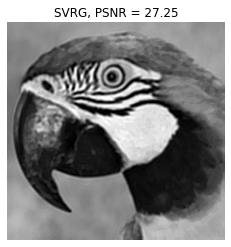

In [60]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

# Subsample rate of 2

(512, 512)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


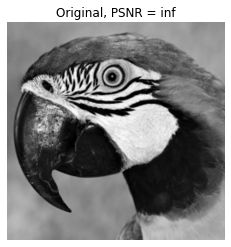

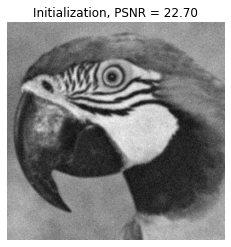

In [2]:
height = 512
width = 512
scaling = 50

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=10/256, blur_size_x=9, blur_size_y=9,  scale_percent=scaling, lr_decay=1)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 255.5, 255.5, -0.5)

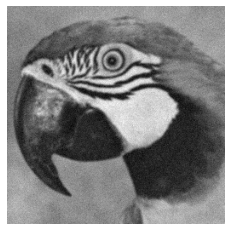

In [3]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [22]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.012, patch_size=5, patch_distance=9, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.1, tt=30, T2=1, 
                                                   mini_batch_size=problem.num_meas//1, verbose=True)

After gradient update: 0 0 23.092622603329005
After denoising update: 0 0 23.206384572869283

After gradient update: 1 0 23.566442208386817
After denoising update: 1 0 23.694153726089272

After gradient update: 2 0 24.027784777905943
After denoising update: 2 0 24.146739083270013

After gradient update: 3 0 24.455331814552594
After denoising update: 3 0 24.548362831309205

After gradient update: 4 0 24.832271881797965
After denoising update: 4 0 24.897326227156565

After gradient update: 5 0 25.156723558547036
After denoising update: 5 0 25.199108896740654

After gradient update: 6 0 25.43446698742172
After denoising update: 6 0 25.45967050732154

After gradient update: 7 0 25.67206640448291
After denoising update: 7 0 25.686285178447985

After gradient update: 8 0 25.877167165087688
After denoising update: 8 0 25.882431513600146

After gradient update: 9 0 26.053668591038527
After denoising update: 9 0 26.052109187091336

After gradient update: 10 0 26.20554103687935
After denoising u

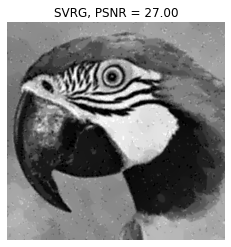

In [23]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)

# Subsample rate of 4

In [ ]:
height = 128
width = 128
subsample_rate = 4

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0.1, subsampling=subsample_rate)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

In [ ]:
measurements = problem.y.reshape(height//subsample_rate,width//subsample_rate)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [ ]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.001, tt=100, T2=10, 
                                                   mini_batch_size=problem.num_meas//10, verbose=True)

In [ ]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=128, W=128)